   OBJECTID REGION DIVISION STATEFP   STATENS GEOID STUSPS        NAME LSAD  \
0        56      4        9      06  01779778    06     CA  California   00   
0        56      4        9      06  01779778    06     CA  California   00   
0        56      4        9      06  01779778    06     CA  California   00   
0        56      4        9      06  01779778    06     CA  California   00   
0        56      4        9      06  01779778    06     CA  California   00   
0        56      4        9      06  01779778    06     CA  California   00   
0        56      4        9      06  01779778    06     CA  California   00   

   MTFCC FUNCSTAT         ALAND        AWATER     INTPTLAT      INTPTLON  \
0  G4000        A  4.034672e+11  2.049980e+10  +37.1551773  -119.5434183   
0  G4000        A  4.034672e+11  2.049980e+10  +37.1551773  -119.5434183   
0  G4000        A  4.034672e+11  2.049980e+10  +37.1551773  -119.5434183   
0  G4000        A  4.034672e+11  2.049980e+10  +37.1551773  -11

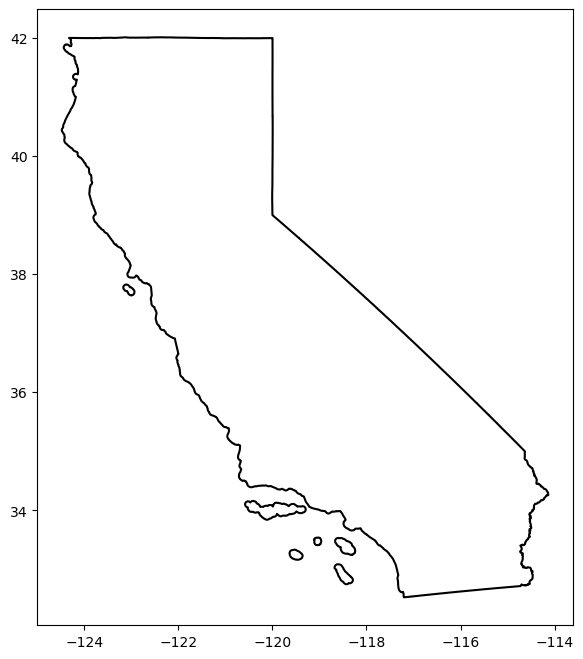

In [3]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

gdf = gpd.read_file('CA_State.shp')
gdf = gdf.to_crs("EPSG:4326")
state_shape = gdf.geometry.union_all()

fig, ax = plt.subplots(figsize=(10, 8))
gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)

data = gdf.explode()
print(data)

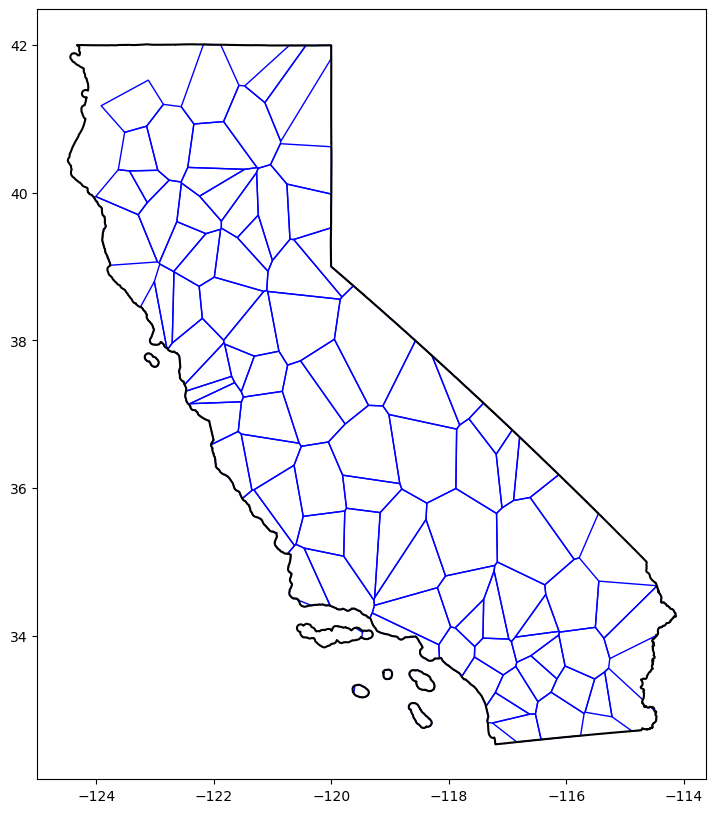

In [6]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union, voronoi_diagram, clip_by_rect
from scipy.spatial import Voronoi
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

# Load shapefile and convert to EPSG:4326
gdf = gpd.read_file('CA_State.shp')
gdf = gdf.to_crs("EPSG:4326")
state_shape = gdf.union_all() # This merges all polygons into one

# Generate random points inside the shape
num_points = 100
minx, miny, maxx, maxy = state_shape.bounds
points = []
while len(points) < num_points:
    pnt = Point(np.random.uniform(minx, maxx), np.random.uniform(miny, maxy))
    if state_shape.contains(pnt):
        points.append(pnt)

# Convert to numpy array for Voronoi
points_array = np.array([[p.x, p.y] for p in points])
vor = Voronoi(points_array)

# Convert Voronoi regions to polygons and clip to state boundary
regions = []
for region_index in vor.point_region:
    region = vor.regions[region_index]
    if not region or -1 in region:  # Skip open regions
        continue
    polygon = Polygon([vor.vertices[i] for i in region])
    if polygon.is_valid:
        clipped = polygon.intersection(state_shape)
        if not clipped.is_empty:
            regions.append(clipped)

# Create a GeoDataFrame of the clipped polygons
voronoi_gdf = gpd.GeoDataFrame(geometry=regions, crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)
voronoi_gdf.plot(ax=ax, edgecolor='blue', facecolor='none')
plt.show()

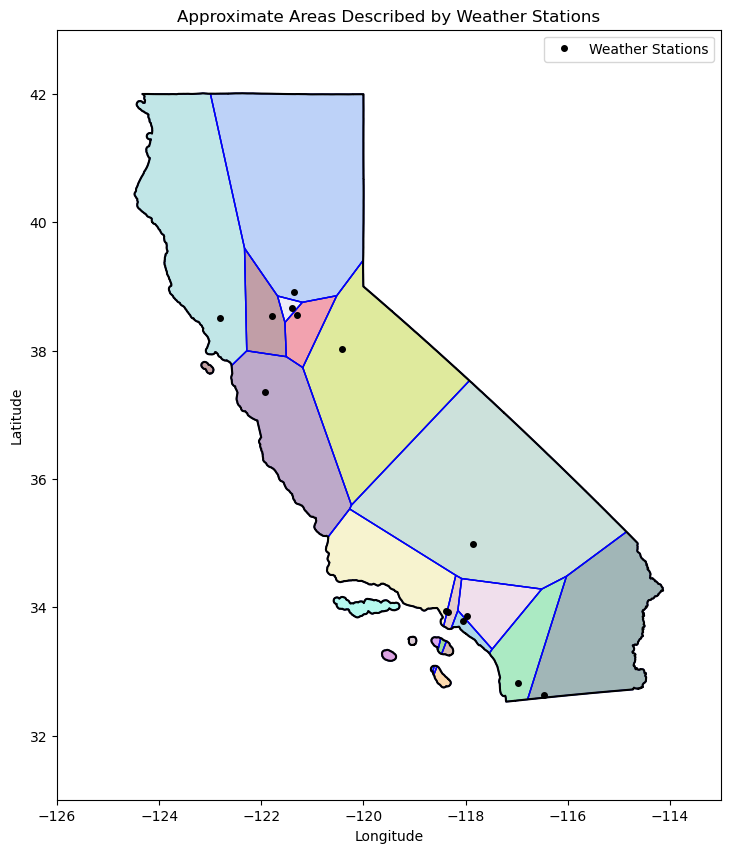

In [26]:
import geopandas as gpd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon as ShapelyPolygon, MultiPolygon
from shapely.ops import unary_union
from scipy.spatial import Voronoi
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

# Load shapefile and unify the boundary
gdf = gpd.read_file('CA_State.shp')
gdf = gdf.to_crs("EPSG:4326")
state_shape = gdf.union_all()

# Load coordinates from Excel
coord = pd.read_excel('2015_to_2019.xlsx')
coord_unique = coord.drop_duplicates(subset=['Latitude', 'Longitude'])
points = coord_unique[['Longitude','Latitude']].to_numpy()

# Add bounding points to avoid infinite regions
points = np.append(points, [[-140,45], [-140,25], [-100,45], [-100,25]], axis=0)

vor = Voronoi(points)

# Prepare plot elements
regions = []
patches = []
colors = []

for region_index in vor.point_region:
    region = vor.regions[region_index]
    if not region or -1 in region:
        continue
    polygon = ShapelyPolygon([vor.vertices[i] for i in region])
    if polygon.is_valid:
        clipped = polygon.intersection(state_shape)
        if not clipped.is_empty:
            regions.append(clipped)
            if clipped.geom_type == "Polygon":
                coords = np.array(clipped.exterior.coords)
                patches.append(MplPolygon(coords, closed=True))
                colors.append(np.random.rand(3))
            elif clipped.geom_type == "MultiPolygon":
                for poly in clipped.geoms:
                    coords = np.array(poly.exterior.coords)
                    patches.append(MplPolygon(coords, closed=True))
                    colors.append(np.random.rand(3))

# Create a GeoDataFrame of the clipped Voronoi regions
voronoi_gdf = gpd.GeoDataFrame(geometry=regions, crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
p = PatchCollection(patches, facecolor=colors, edgecolor='black', alpha=0.4)
ax.add_collection(p)
gdf.boundary.plot(ax=ax, color='black', linewidth=1.5)
voronoi_gdf.plot(ax=ax, edgecolor='blue', facecolor='none')
ax.plot(points[:, 0], points[:, 1], 'ko', markersize=4, label='Weather Stations')
ax.set_xlim(-126, -113)
ax.set_ylim(31, 43)
ax.legend()
ax.set_title('Approximate Areas Described by Weather Stations')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()